In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
from plot_params import *

indir1 = '/home/hsher/scratch/circ_nextera_iter12/output/'
circ_quant_output = [os.path.join(indir1,f) for f in os.listdir(indir1) if f.endswith('.gtf')]

# the basic rar11 recipe
indir = '/home/hsher/scratch/circ_nextera_iter2/output/'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf') 
                      and f.startswith('HEK_rar11')]

indir3 = '/home/hsher/scratch/circ_nextera/output/'
circ_quant_output += [os.path.join(indir3,f) for f in os.listdir(indir3) if f.endswith('.gtf') 
                      and f.startswith('circseq-bm-rar11-nxt')]



In [2]:
circ_quant_output

['/home/hsher/scratch/circ_nextera_iter12/output/K562_rep2_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter12/output/K562_rep1_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter12/output/HepG2_rep2_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter12/output/HeLa_rep1_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter12/output/HepG2_rep1_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter12/output/HeLa_rep2_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter2/output/HEK_rar11.gtf',
 '/home/hsher/scratch/circ_nextera/output/circseq-bm-rar11-nxt.gtf']

In [3]:
def read_ciri_gtf(fname):
    bed = BedTool(fname)
    df = bed.to_dataframe()
    # filter for non-entries
    stat = df.loc[df['seqname'].str.contains('##'), 'seqname'].str.split(': ', expand = True)
    df = df.loc[~df['seqname'].str.contains('##')].reset_index()
    
    # get attributes
    attrs = pd.DataFrame([i.attrs for i in bed])
    
    return pd.concat([df, attrs], axis = 1), stat

In [4]:
circ_type_count = []
names = []
junc_ratio_tbl = []
bsj_ratio_tbl = []
fsj_ratio_tbl = []
stats = []
mega_anno = []

features = ['seqname', 'start', 'end', 
       'strand', 'circ_type', 'gene_id', 'gene_name', 'gene_type']

for fname in circ_quant_output:
    name = os.path.basename(fname).replace('.gtf', '')
    names.append(name)
    
    circ_df, stat = read_ciri_gtf(fname)
    
    circ_type_count.append(circ_df['circ_type'].value_counts())
    
    junc_ratio_tbl.append(circ_df.set_index('circ_id')['junc_ratio'].astype(float))
    bsj_ratio_tbl.append(circ_df.set_index('circ_id')['bsj'].astype(float))
    fsj_ratio_tbl.append(circ_df.set_index('circ_id')['fsj'].astype(float))
    stats.append(stat.set_index(0))
    mega_anno.append(circ_df.set_index('circ_id')[features])
mega_anno = pd.concat(mega_anno, axis = 0).drop_duplicates()

In [5]:
stats_df = pd.concat(stats, axis = 1).T

In [6]:
for col in ['##Total_Reads', '##Mapped_Reads', '##Circular_Reads']:
    stats_df[col] = stats_df[col].astype(int)

In [7]:
stats_df['frac_circular'] = stats_df['##Circular_Reads']/stats_df['##Mapped_Reads']
stats_df['frac_mapped'] = stats_df['##Mapped_Reads']/stats_df['##Total_Reads']

In [8]:
stats_df.sort_values('frac_circular')
stats_df.set_index('##Sample', inplace = True)

In [9]:
stats_df

,##Total_Reads,##Mapped_Reads,##Circular_Reads,##version,frac_circular,frac_mapped
##Sample,,,,,,
K562_rep2_rar11,121234652,103575430,2470854,1.1.2,0.023856,0.854338
K562_rep1_rar11,119847686,104673154,1944764,1.1.2,0.018579,0.873385
HepG2_rep2_rar11,117490276,99888226,2944574,1.1.2,0.029479,0.850183
HeLa_rep1_rar11,112922030,98380672,2733644,1.1.2,0.027786,0.871227
HepG2_rep1_rar11,115035274,98453510,3450508,1.1.2,0.035047,0.855855
HeLa_rep2_rar11,118506386,100805144,3549726,1.1.2,0.035214,0.850630
HEK_rar11,288352678,238307158,5730676,1.1.2,0.024047,0.826443
circseq-bm-rar11-nxt,337446430,294910186,4307176,1.1.2,0.014605,0.873947


In [10]:
counts = pd.concat(circ_type_count, axis = 1)
counts.columns = names

In [11]:
bsj = pd.concat(bsj_ratio_tbl, axis = 1)
bsj.columns = names

In [12]:
fsj = pd.concat(fsj_ratio_tbl, axis = 1)
fsj.columns = names

In [13]:
junc = pd.concat(junc_ratio_tbl, axis = 1)
junc.columns = names

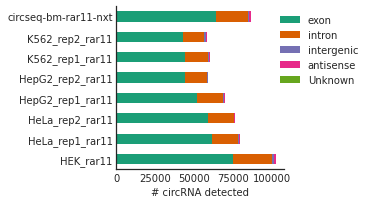

In [14]:
import matplotlib.pyplot as plt
counts.T.sort_index().plot.barh(stacked = True, figsize = (3,3))
plt.xlabel('# circRNA detected')
plt.legend(bbox_to_anchor = (1.5, 1))
sns.despine()
plt.savefig(figdir / '5_n_circles.pdf')

# Overlap between circular RNAs in cell line

In [15]:
bsj

,K562_rep2_rar11,K562_rep1_rar11,HepG2_rep2_rar11,HeLa_rep1_rar11,HepG2_rep1_rar11,HeLa_rep2_rar11,HEK_rar11,circseq-bm-rar11-nxt
circ_id,,,,,,,,
chr1:746436|749381,72.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
chr1:746695|749381,62.0,166.0,NaN,5.0,27.0,113.0,134.0,149.0
chr1:805799|810170,82.0,33.0,124.0,118.0,134.0,153.0,43.0,68.0
chr1:945177|945517,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chr1:955923|957025,3.0,NaN,1.0,NaN,NaN,6.0,1.0,NaN
...,...,...,...,...,...,...,...,...
chrX:155506898|155511774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
chrX:155506898|155525464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
chrX:155511673|155514290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [16]:
circname_reproducible = {}
for cell_line in ['K562', 'HepG2', 'HeLa']:
    circname_reproducible[cell_line]=set(bsj.loc[~bsj[f'{cell_line}_rep1_rar11'].isnull()].index).intersection(
                                    set(bsj.loc[~bsj[f'{cell_line}_rep2_rar11'].isnull()].index)
    )
circname_reproducible['HEK293']=set(bsj.loc[~bsj[['HEK_rar11', 'circseq-bm-rar11-nxt']].isnull().any(axis = 1)].index)

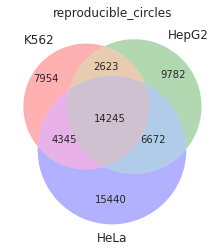

In [17]:
from matplotlib_venn import venn3
venn3([circname_reproducible[p] for p in ['K562', 'HepG2', 'HeLa']]
      , set_labels = ('K562', 'HepG2', 'HeLa'), 
      
      alpha = 0.3
     )
plt.title('reproducible_circles')
plt.savefig(figdir / '5_venn_3cellline.pdf')

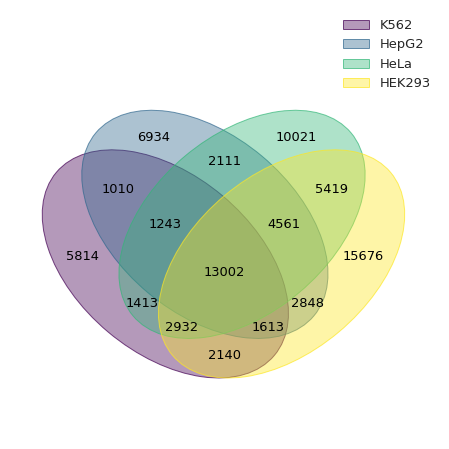

In [18]:
from venn import venn
venn(circname_reproducible)
plt.savefig(figdir / '5_venn_4cellline.pdf')

# Correlating CPM levels

In [19]:
cpm=bsj.div(stats_df['##Total_Reads'], axis = 1)*10**6

/home/hsher/miniconda3/envs/Metadensity/lib/python3.9/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


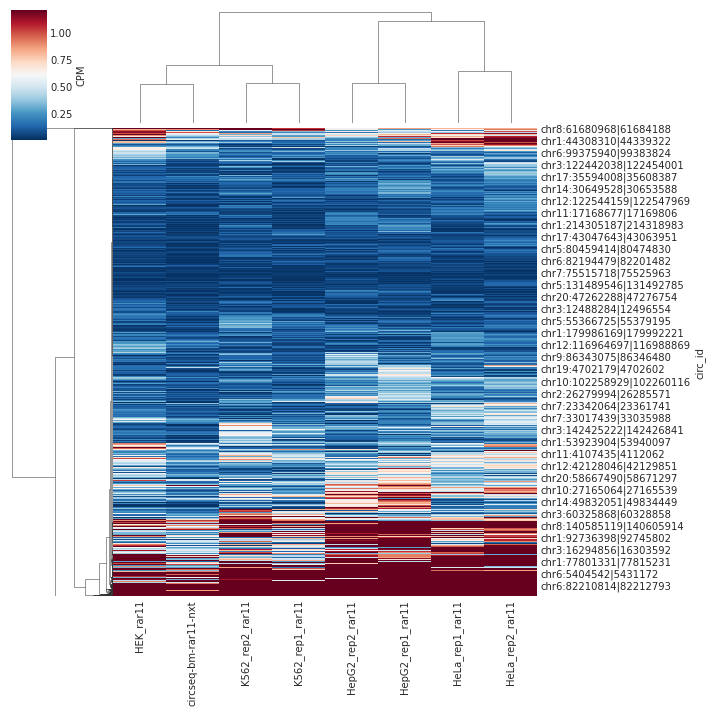

In [20]:
all_expressed = cpm.loc[cpm.isnull().sum(axis = 1)<1]
max_value = all_expressed.mean().median()
sns.clustermap(all_expressed, cmap = 'RdBu_r', vmax = max_value*2, 
              cbar_kws = {'label':'CPM'})
plt.savefig(figdir / '5_cell_line_CPM_clust.pdf')

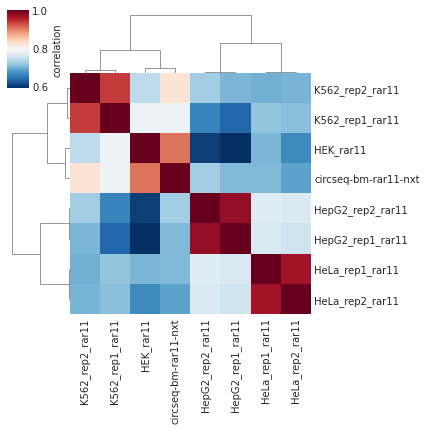

In [21]:
from scipy.spatial.distance import pdist, squareform
corr = pd.DataFrame(1-squareform(pdist(all_expressed.T, 'correlation')),
                    index = all_expressed.columns,
                    columns = all_expressed.columns)

sns.clustermap(corr, metric = 'correlation', cmap = 'RdBu_r', figsize = (6,6), cbar_kws = {'label': 'correlation'})
plt.savefig(figdir / '5_cell_line_CPM_corr.pdf')

# Differentially expressed circles

# Other analysis: what contributes to differentially expressed circles
- linear RNA expression: download from CCLE [here](https://www.ebi.ac.uk/gxa/experiments/E-MTAB-2770/Results)
- [link](https://www.ebi.ac.uk/gxa/experiments-content/E-MTAB-2770/resources/ExperimentDownloadSupplier.RnaSeqBaseline/fpkms.tsv)

- cell type specific casette exons?
- intron lengths

# The same gene express different circles?

In [22]:
cpm.rename({'circseq-bm-rar11-nxt':'HEK_rar11_rep2'}, axis = 1, inplace = True)

In [23]:
mega_anno.loc[cpm.loc[cpm.isnull().sum(axis = 1)<3].index]['gene_name'].value_counts()

SMARCC1                 65
BIRC6                   57
PPP6R3                  47
PDS5A                   43
USP34                   43
                        ..
PAK1                     1
NDUFC2-KCTD14,NDUFC2     1
PCF11                    1
ANKRD42,AP000873.5       1
MBNL3                    1
Name: gene_name, Length: 6370, dtype: int64

In [24]:
coords = BedTool('/home/hsher/gencode_coords/gencode.v35.annotation.gff3')
from collections import defaultdict
exon_dict = defaultdict(lambda: list())
for c in coords:
    if c[2]=='exon':
        exon_dict[c.attrs['gene_name']].append([c.start, c.end])

In [25]:
def plot_bsj(gene):
    sub = cpm.loc[mega_anno.loc[mega_anno['gene_name']==gene].index]
    
    print(sub.shape)
    clines = sorted(list(sub.columns))
    max_cpm = sub.max().max()
    sub['start']=mega_anno['start']
    sub['end']=mega_anno['end']
    
    print(clines)
    f, ax = plt.subplots(1,int(len(clines)/2),  figsize = (int(3*len(clines)/2),3), sharex = True, sharey = True)
    for i,c in enumerate(clines): 
        if i%2==0:
            ax[i//2].scatter(sub['start'], sub['end'], (sub[c]/max_cpm)*10, label = c)
        else:
            ax[i//2].scatter(sub['end'],sub['start'],  (sub[c]/max_cpm)*10, label = c)
        ax[i//2].set_title(c.split('_')[0])
        ax[i//2].text(sub['start'].min(), sub['end'].max(), 'rep1')
        ax[i//2].text(sub['end'].max(), sub['start'].min(), 'rep2')
    sns.despine()
    
    # _ = [a.legend() for a in ax]
    _ = [a.set_ylabel('BSJ start/end') for a in ax]
    _ = [a.set_xlabel('BSJ start/end') for a in ax]
    
    min_ax = min([i[0] for i in exon_dict[gene]])
    max_ax = max([i[1] for i in exon_dict[gene]])
    # for a in ax:
    #     for exon in exon_dict[gene]:
    #         #print(exon, min_ax, max_ax)
    #         # if exon[0]>sub['start'].min():
    #         a.plot([min_ax]*2, exon, linewidth=7.0, color = 'lightgrey')
    #         a.plot(exon, [min_ax]*2,  linewidth=7.0, color = 'lightgrey')
    #         a.axhspan(exon[0], exon[1], xmin=min_ax, xmax=max_ax, color = 'lightgrey')
    #         a.axvspan(exon[0], exon[1], ymin=min_ax, ymax=max_ax, color = 'lightgrey')
            
    _ = [a.plot([min_ax, max_ax], [min_ax, max_ax], '--', color = 'black') for a in ax]
    
    plt.suptitle(gene)

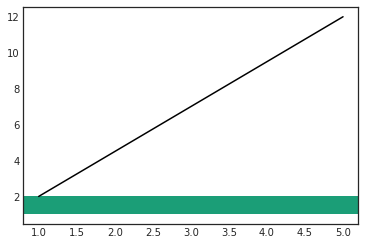

In [26]:

plt.plot([1,1,5], [2,2,12], color = 'black')
plt.axhspan(1,2)

(216, 8)
['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


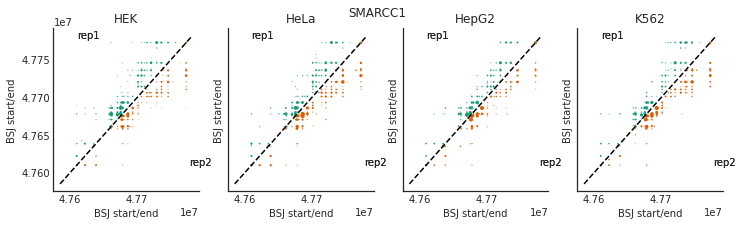

In [27]:
plot_bsj('SMARCC1')
plt.savefig(figdir / '5_BSJ_in_SMARCC1.pdf')

(177, 8)
['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


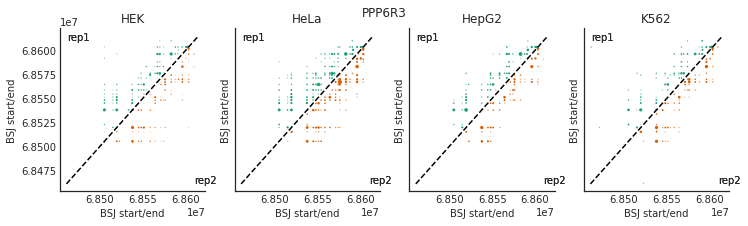

In [28]:
plot_bsj('PPP6R3')
plt.savefig(figdir / '5_BSJ_in_PPP6R3.pdf')

(308, 8)
['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


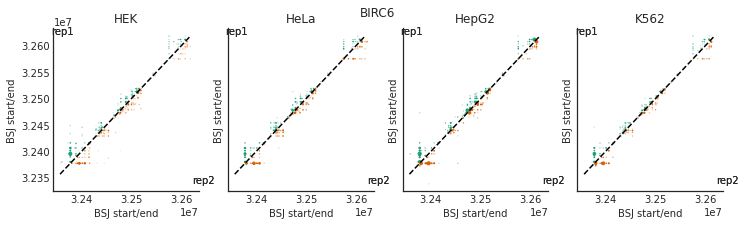

In [29]:
plot_bsj('BIRC6')
plt.savefig(figdir / '5_BSJ_in_BIRC6.pdf')

(186, 8)
['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


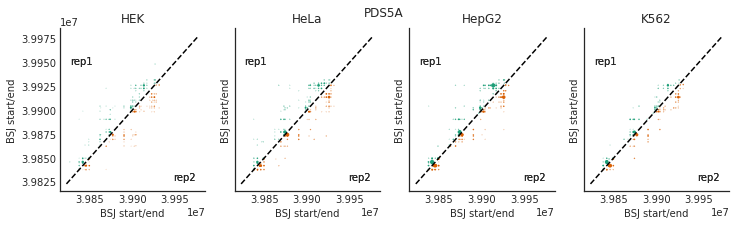

In [30]:
plot_bsj('PDS5A')
plt.savefig(figdir / '5_BSJ_in_PDS5A.pdf')

(282, 8)
['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


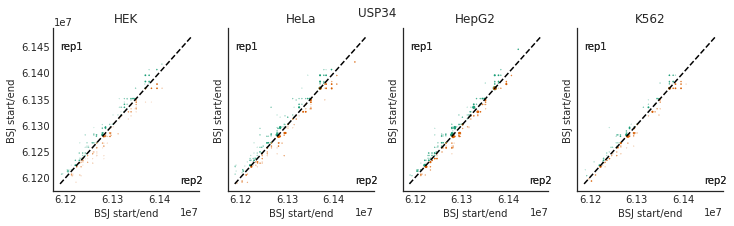

In [31]:
plot_bsj('USP34')
plt.savefig(figdir / '5_BSJ_in_USP34.pdf')

In [32]:
linear_rpkm = pd.read_csv('/projects/ps-yeolab5/hsher/ccle_datasets/CCLE_RNAseq_genes_rpkm_20180929.gct.gz',
                     skiprows = 2,
                     sep = '\t')

In [33]:
linear_rpkm.drop_duplicates(subset = ['Description'], inplace = True)

In [34]:
gene_length = {}
for c in coords:
    if c[2]=='gene':
        gene_length[c.attrs['gene_name']]=c.end-c.start

In [35]:
linear_rpkm['length']=linear_rpkm['Description'].map(gene_length)

In [36]:
linear_cpm = []
for c in cols:
    cpm_value=linear_rpkm.set_index('Description')[c]*linear_rpkm.set_index('Description')['length']
    cpm_value.name = c
    linear_cpm.append(cpm_value)
linear_cpm = pd.concat(linear_cpm, axis = 1)

NameError: name 'cols' is not defined

In [ ]:
cols = ['HEPG2_LIVER','K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE','HEKTE_KIDNEY','HELA_CERVIX']


In [ ]:
cpm['gene_name']=mega_anno['gene_name']
circ_cpm_sum_pergene = cpm.groupby(by = 'gene_name').sum()
circ_cpm_sum_pergene = pd.concat([linear_cpm,circ_cpm_sum_pergene],axis = 1).dropna()

In [ ]:
corr = pd.DataFrame(1-squareform(pdist(circ_cpm_sum_pergene.T, 'correlation')),
                    index = circ_cpm_sum_pergene.columns,
                    columns = circ_cpm_sum_pergene.columns)

sns.clustermap(corr, metric = 'correlation', cmap = 'RdBu_r', figsize = (6,6), cbar_kws = {'label': 'correlation'})
# plt.savefig(figdir / '5_cell_line_CPM_corr.pdf')



In [ ]:
circ_cpm_sum_pergene.plot.scatter(x = 'K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
                                  y = 'K562_rep1_rar11',
                                 figsize = (3,3))
plt.ylabel('Sum CPM of all circRNA \n in Linear gene')
plt.xlabel('Linear RNA CPM')
sns.despine()

In [ ]:
circ_cpm_sum_pergene.plot.scatter(x = 'HEPG2_LIVER',
                                  y = 'HepG2_rep1_rar11',
                                 figsize = (3,3))
plt.ylabel('Sum CPM of all circRNA \n in Linear gene')
plt.xlabel('Linear RNA CPM')
sns.despine()

In [ ]:
circ_cpm_sum_pergene.plot.scatter(x = 'HELA_CERVIX',
                                  y = 'HeLa_rep1_rar11',
                                 figsize = (3,3))
plt.ylabel('Sum CPM of all circRNA \n in Linear gene')
plt.xlabel('Linear RNA CPM')
sns.despine()